# House Price Prediction-(Pipeline Method) 

In [1]:
# Update the libraries

!conda update --all -y

Solving environment: done

# All requested packages already installed.



**Libraries used**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from sklearn.impute import KNNImputer, SimpleImputer
from scipy.stats.mstats import winsorize

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, MaxAbsScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import RidgeCV, Ridge, LassoCV
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBRegressor

import os

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (25, 15)
set_config(display='diagram')

**Read the input file nd display contents**

In [4]:
data = pd.read_csv(os.getcwd() + '/train.csv')
data.drop(columns=['Id'], inplace=True)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Price
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**List out all the features in the data that have undefined values**

In [5]:
data.columns[data.isna().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

**Replace the NaN values  (Note: Not all NA are invalid)**

In [7]:
data['MasVnrType'] = data['MasVnrType'].replace(np.nan, data.MasVnrType.value_counts().index[0])
data['Electrical'] = data['Electrical'].replace(np.nan, data.Electrical.value_counts().index[0])

In [8]:
columns = data.drop(['Price'], axis=1).columns
nonObjCols = data.drop(['Price'], axis=1).select_dtypes(exclude=['object']).columns
toScale1 = [key for key, val in (data[nonObjCols].quantile(0.75) == 0.0).to_dict().items() if val == True] 
toScale2 = [val for val in nonObjCols if val not in toScale1]
ObjCols = data.select_dtypes(include=['object']).columns

**Pipelining**

In [9]:
numeric_features2 = toScale2
numeric_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('scaler', RobustScaler())])

numeric_features1 = toScale1
numeric_transformer1 = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('scaler', MaxAbsScaler())]) 
categorical_features = ObjCols
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical1', numeric_transformer1, numeric_features1),
        ('numerical2', numeric_transformer2, numeric_features2),
        ('categorical', categorical_transformer, categorical_features)],
        remainder='drop')

In [10]:
X = data.loc[:, data.columns != 'Price']
y = data.Price

In [11]:
ScaleTarget = RobustScaler()

**Splitting data into Train and Test sets**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=18)
y_train = ScaleTarget.fit_transform(y_train.values.reshape(-1,1))
y_test = ScaleTarget.transform(y_test.values.reshape(-1,1))

**Prediction**

In [13]:
def prediction(X_train, y_train, X_test, y_test, estimator):
        
    print (": Metrics of estimator: ", estimator, "\n")
    
    pipe = Pipeline([('preprocessor', preprocessor), ('estimator', estimator)], verbose=True)
    pipe.fit(X_train, y_train.ravel())
    pred = pipe.predict(X_test)
    
    rmse = mean_squared_error(y_test, pred, squared = False)
    print("RMSE: %.4f" % rmse)
    evs = explained_variance_score(y_test, pred)
    print("EVS: %.4f" % evs)
    score = pipe.score(X_test, y_test)
    print("Score: %.4f" % score)

    MAX = 200
    x = range(len(pred))[0:MAX]
    plt.scatter(x,y_test[0:MAX],color='g', linewidths=5, label='Actual')
    plt.scatter(x,pred[0:MAX],color='r', linewidths=3, label='Predicted')
    plt.plot(pred[0:MAX], color = 'r', linewidth=2)
    plt.ylabel('Sale Price', fontsize=15)
    plt.title(estimator, fontsize=20)
    plt.legend(loc ="upper right", fontsize=20)
    plt.show()
        
    return pipe

**Ridge**

: Metrics of estimator:  Ridge(alpha=16) 

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   0.3s
RMSE: 0.3358
EVS: 0.8860
Score: 0.8858


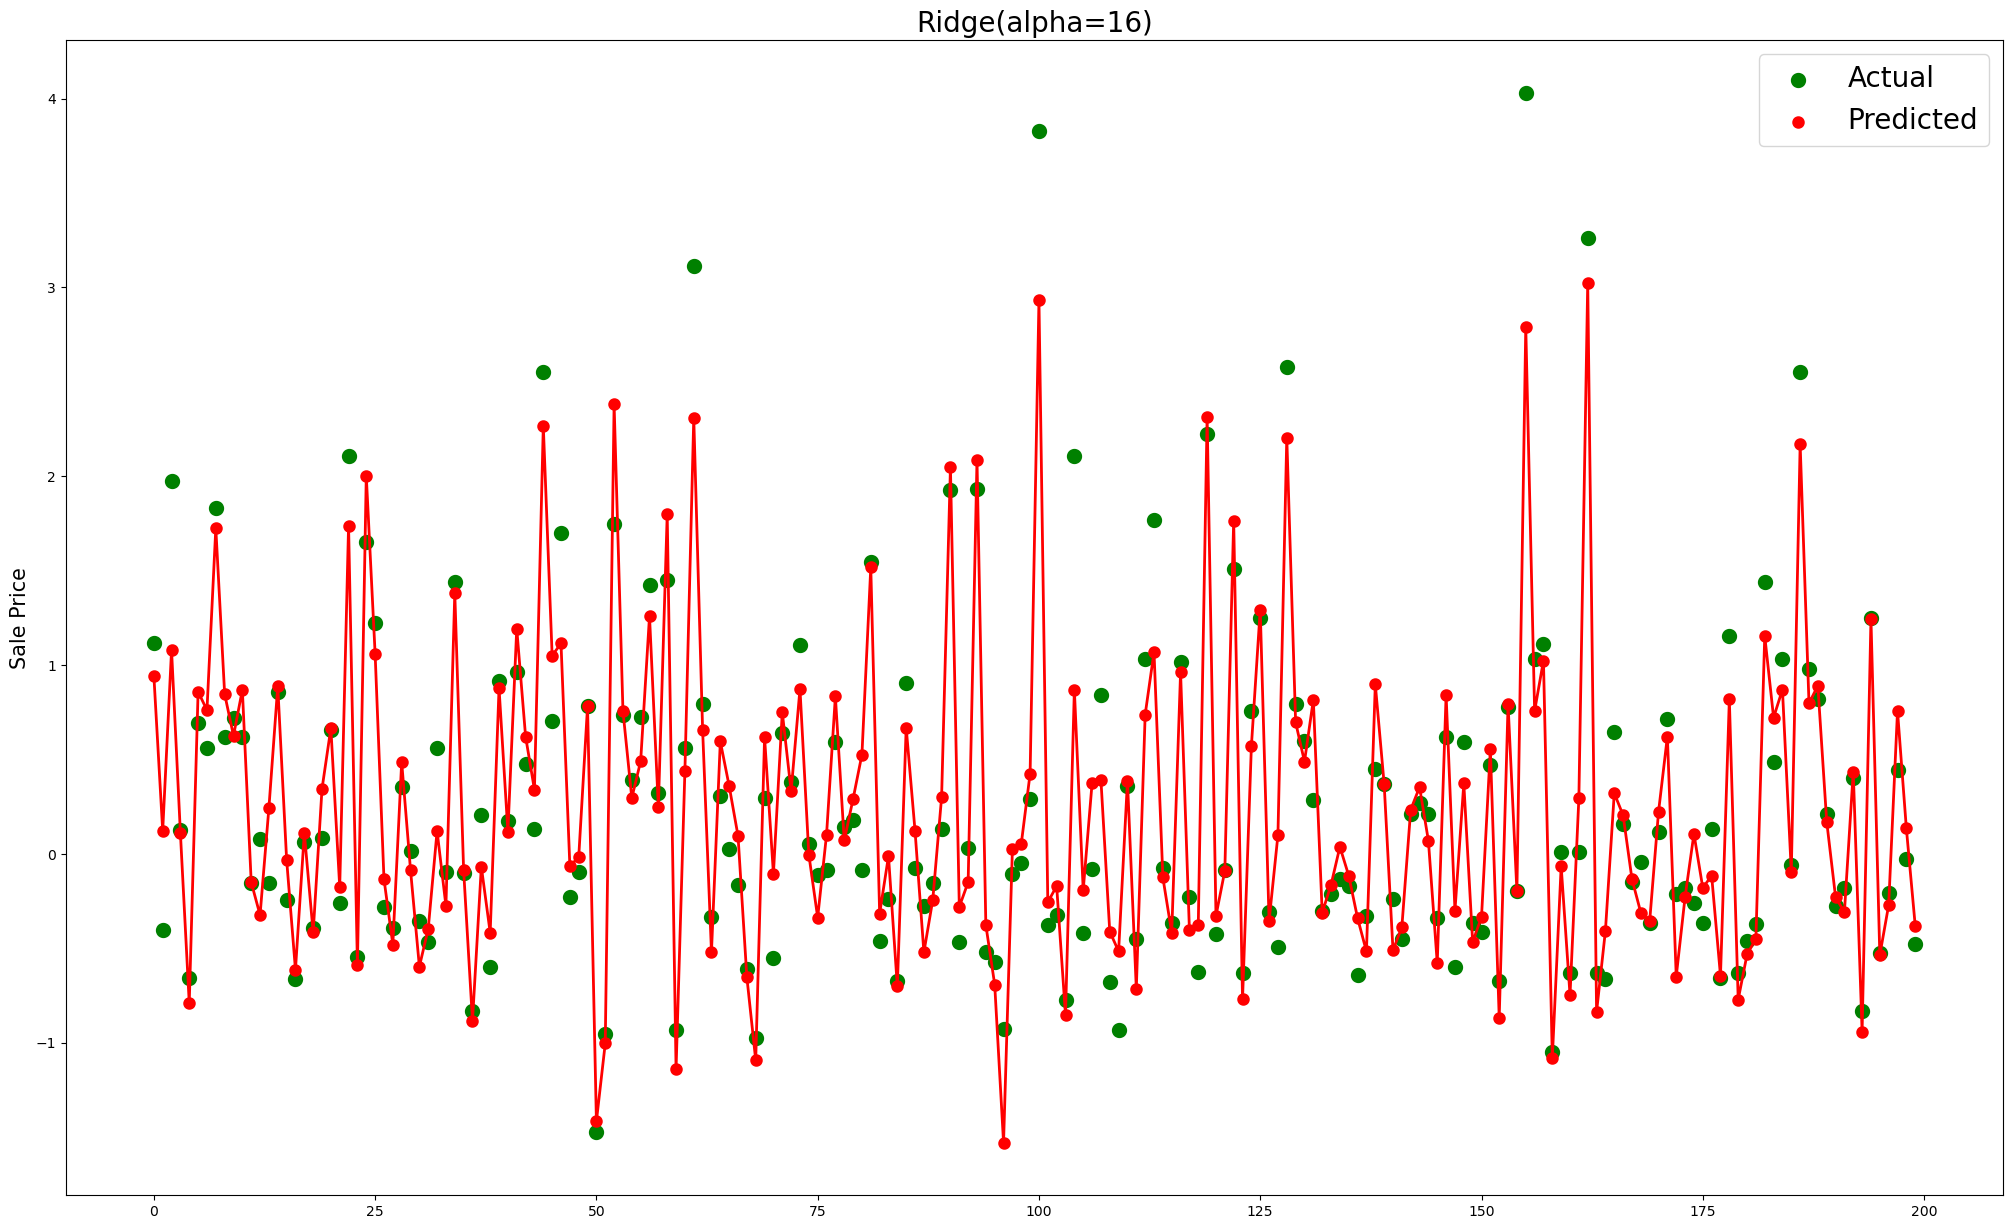

In [14]:
ridge = prediction(X_train, y_train, X_test, y_test, Ridge(alpha=16))

**Ridge CV**

: Metrics of estimator:  RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])) 

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   1.1s
RMSE: 0.3338
EVS: 0.8874
Score: 0.8872


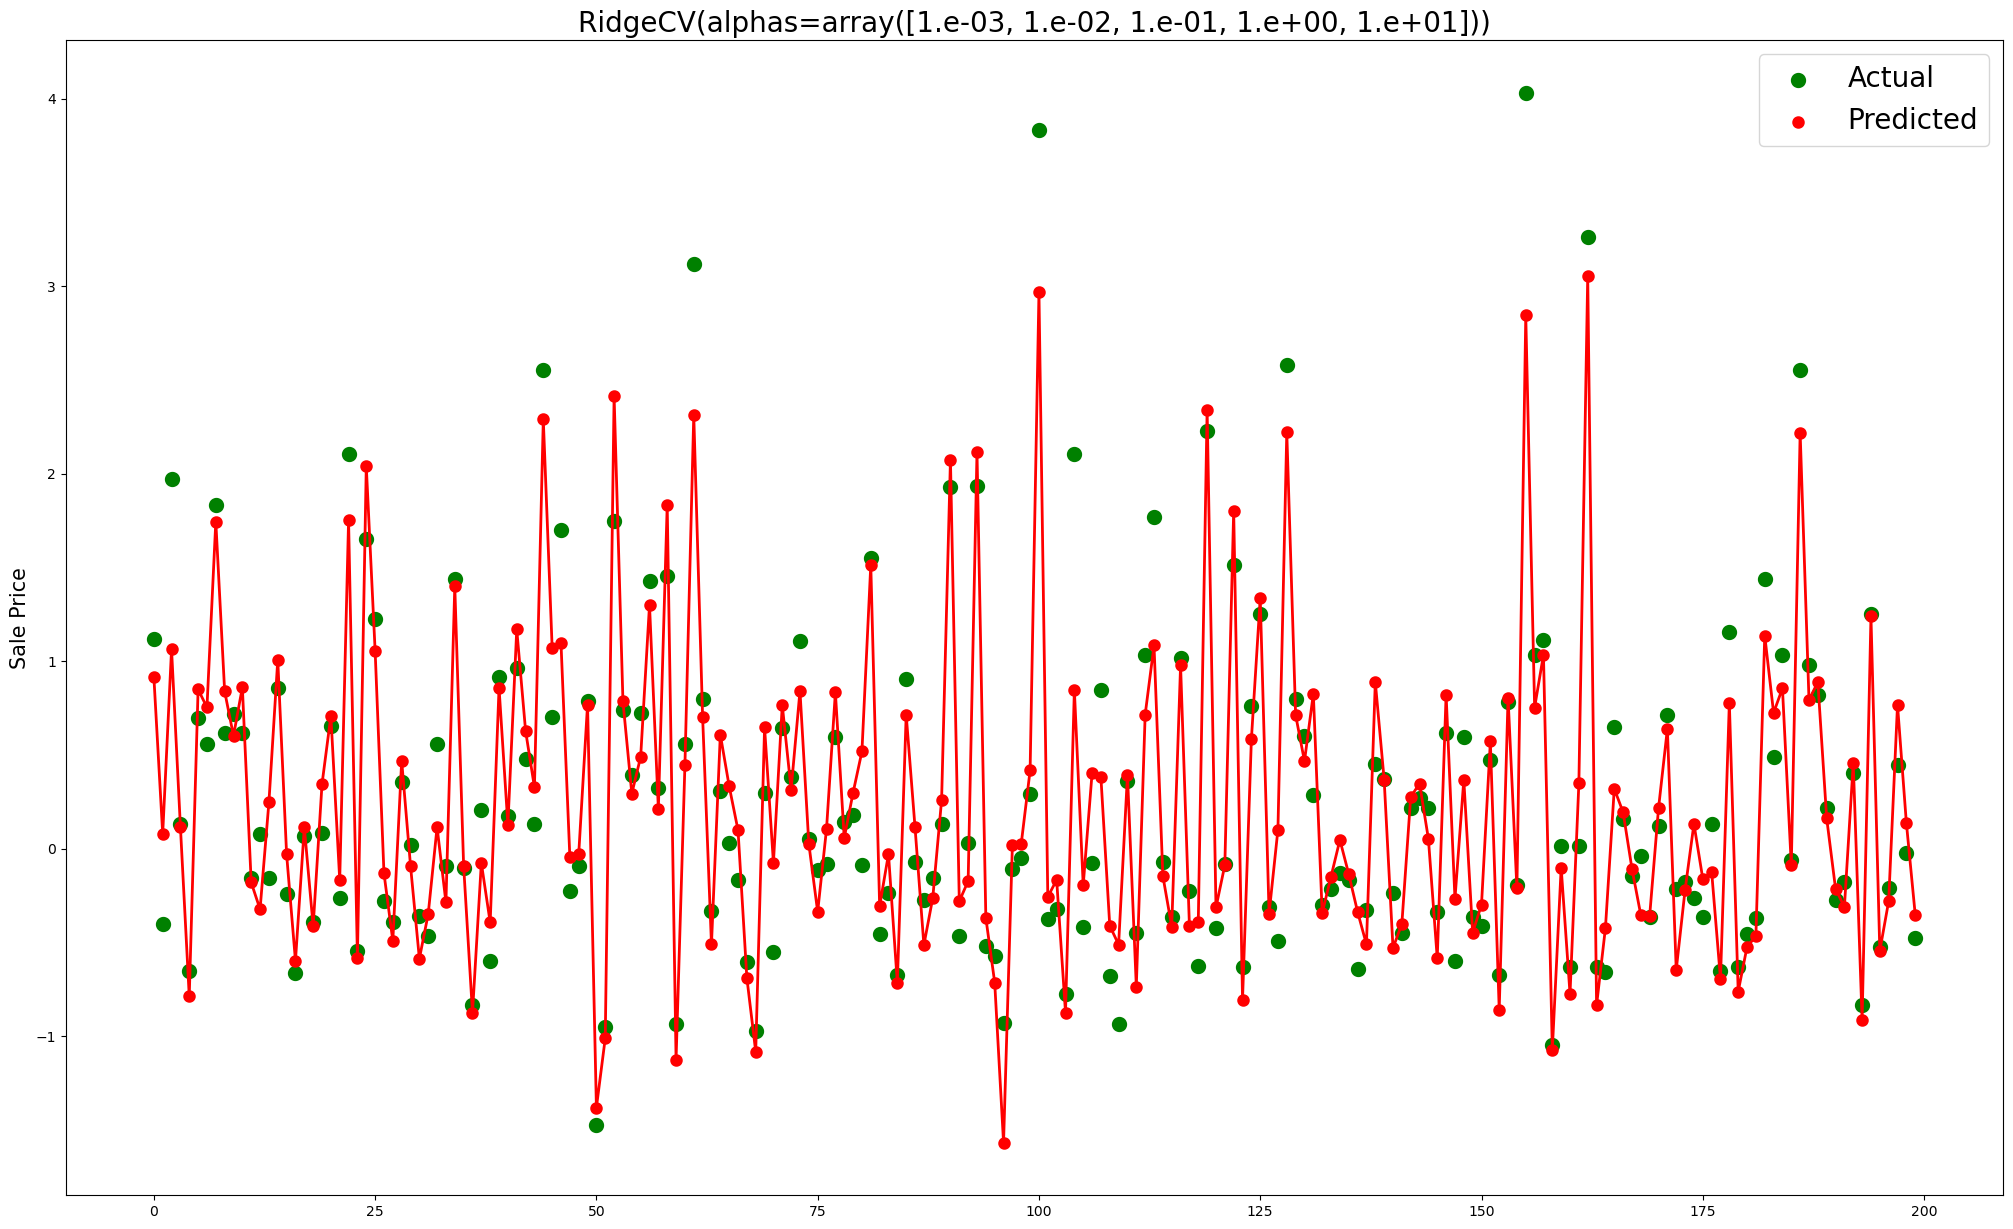

In [15]:
ridgecv = prediction(X_train, y_train, X_test, y_test, RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10]))

**RandomForest**

: Metrics of estimator:  RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      n_estimators=800, n_jobs=-1, random_state=2) 

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=  15.7s
RMSE: 0.3547
EVS: 0.8730
Score: 0.8726


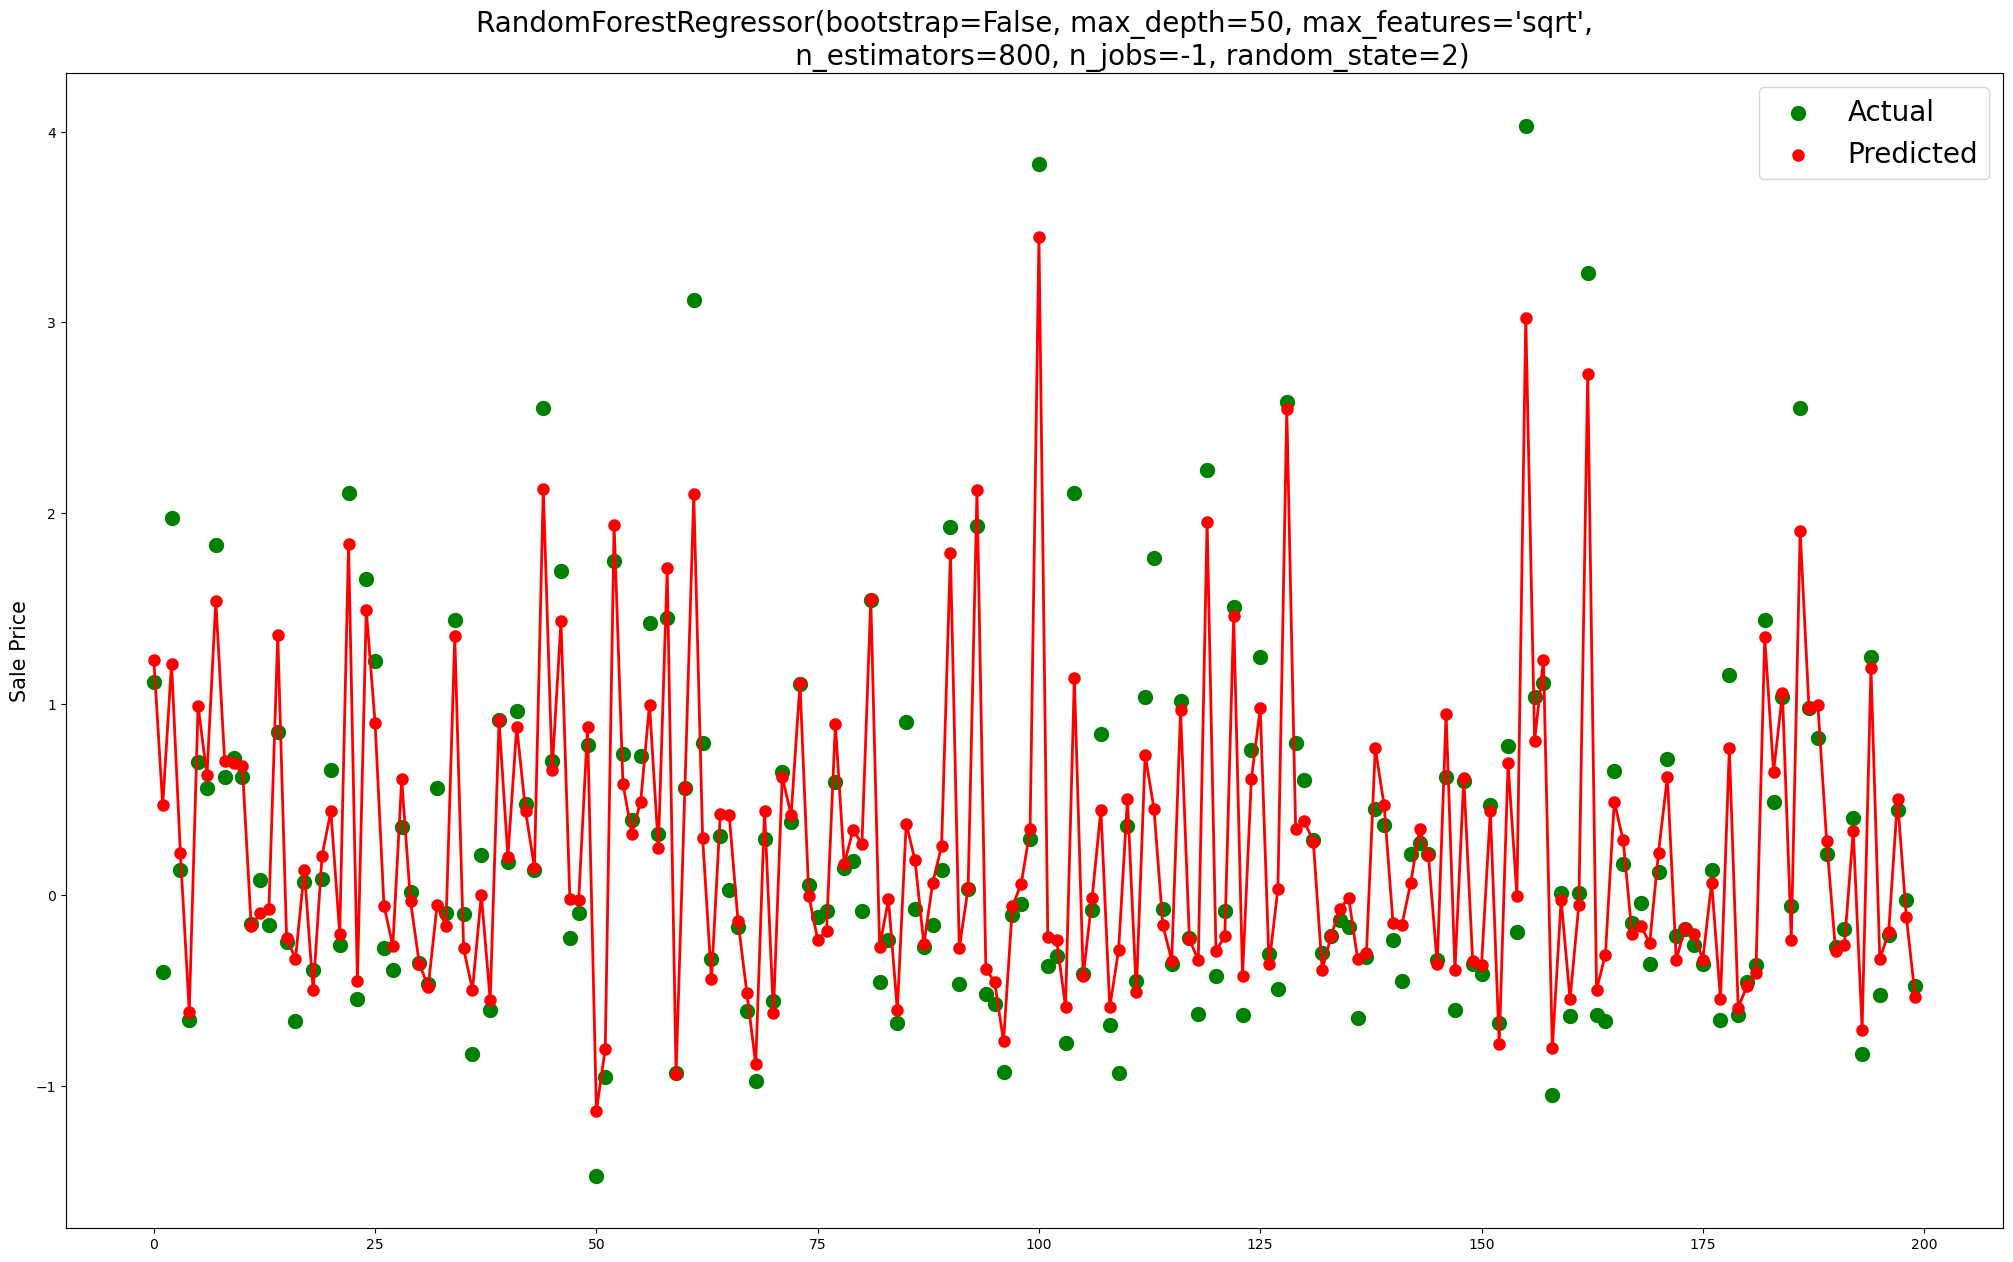

In [16]:
randomforest = prediction(X_train, y_train, X_test, y_test, RandomForestRegressor(n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=50, bootstrap=False, random_state=2, n_jobs=-1))

**XGBoost**

: Metrics of estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   5.1s
RMSE: 0.3189
EVS: 0.8973
Score: 0.8970


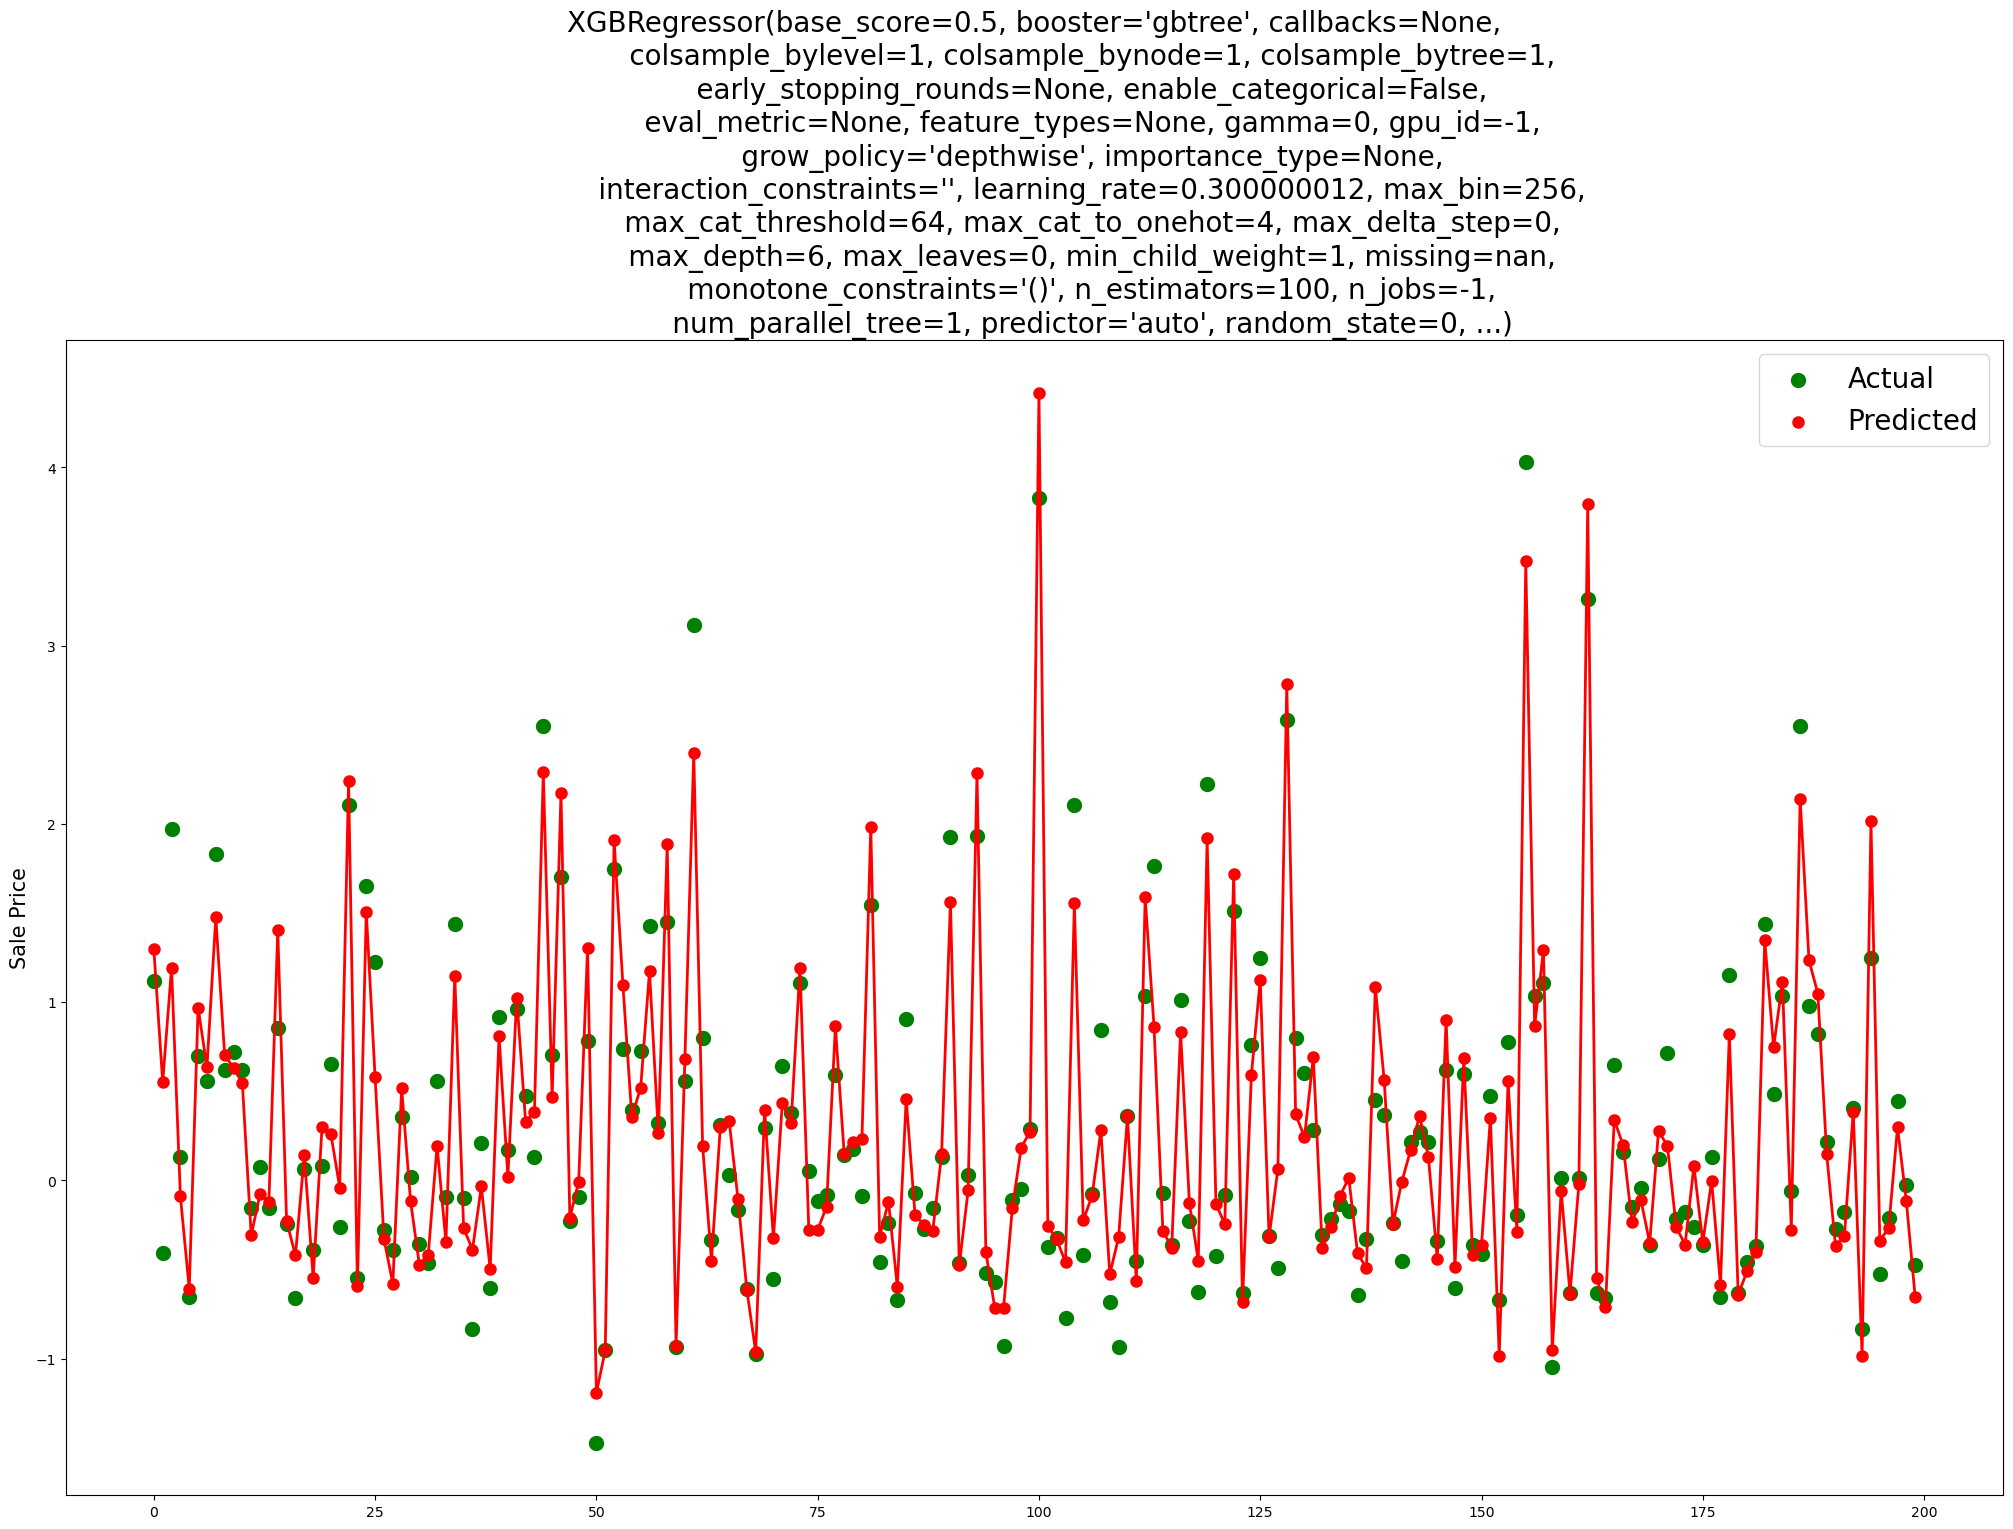

In [17]:
xgb = prediction(X_train, y_train, X_test, y_test, XGBRegressor(n_jobs=-1))

**Gradient Boost**

: Metrics of estimator:  GradientBoostingRegressor(max_depth=2, n_estimators=400, random_state=1,
                          subsample=1) 

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   4.8s
RMSE: 0.2909
EVS: 0.9147
Score: 0.9143


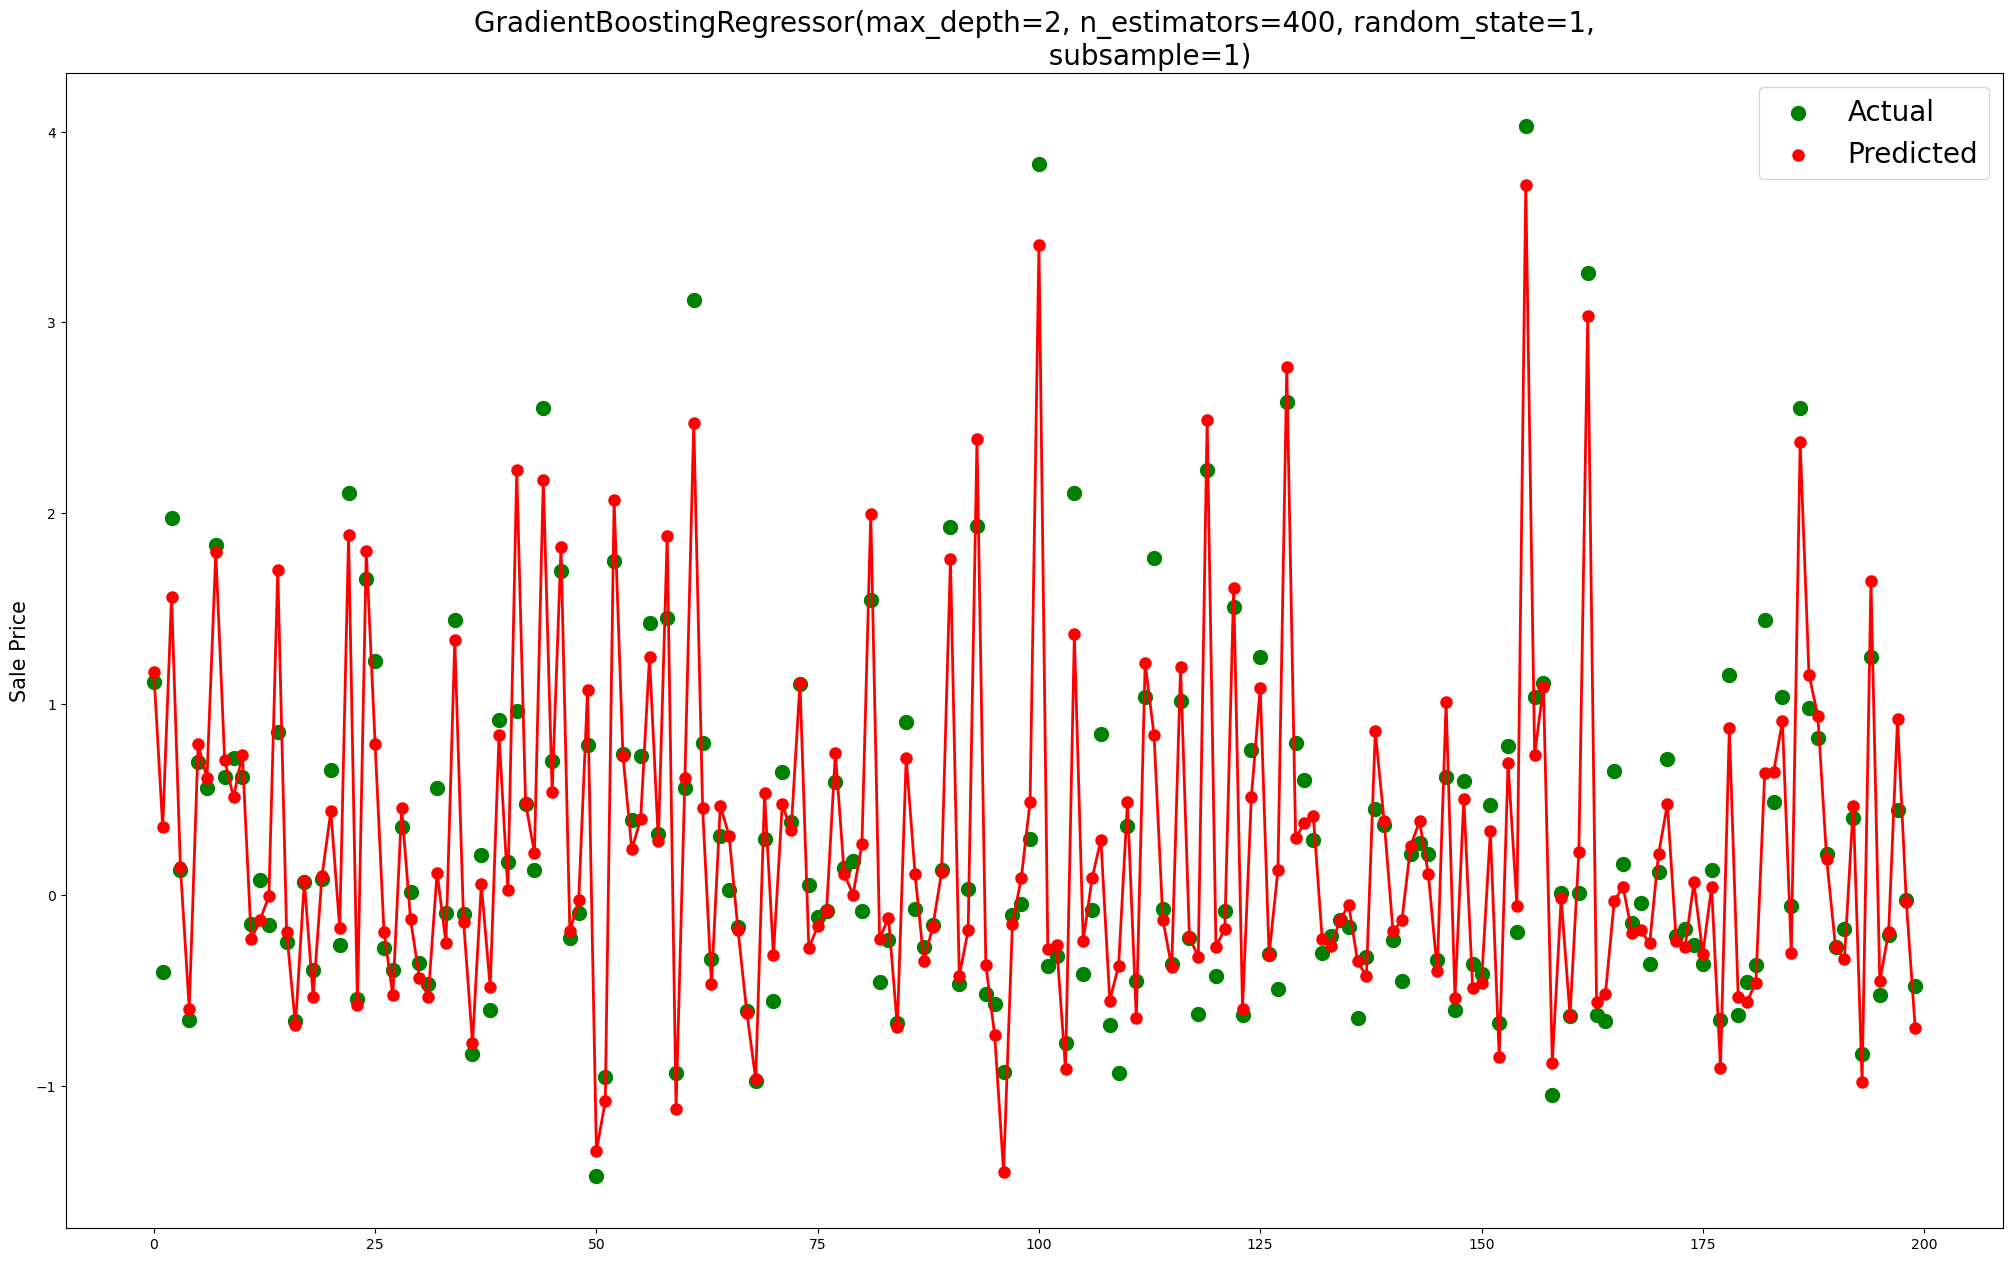

In [18]:
gradientboost = prediction(X_train, y_train, X_test, y_test, GradientBoostingRegressor(n_estimators=400,learning_rate=0.1,max_depth=2,subsample=1,random_state=1))

**Lasso CV**

: Metrics of estimator:  LassoCV(cv=10, n_jobs=-1) 

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=  12.6s
RMSE: 0.3188
EVS: 0.8972
Score: 0.8971


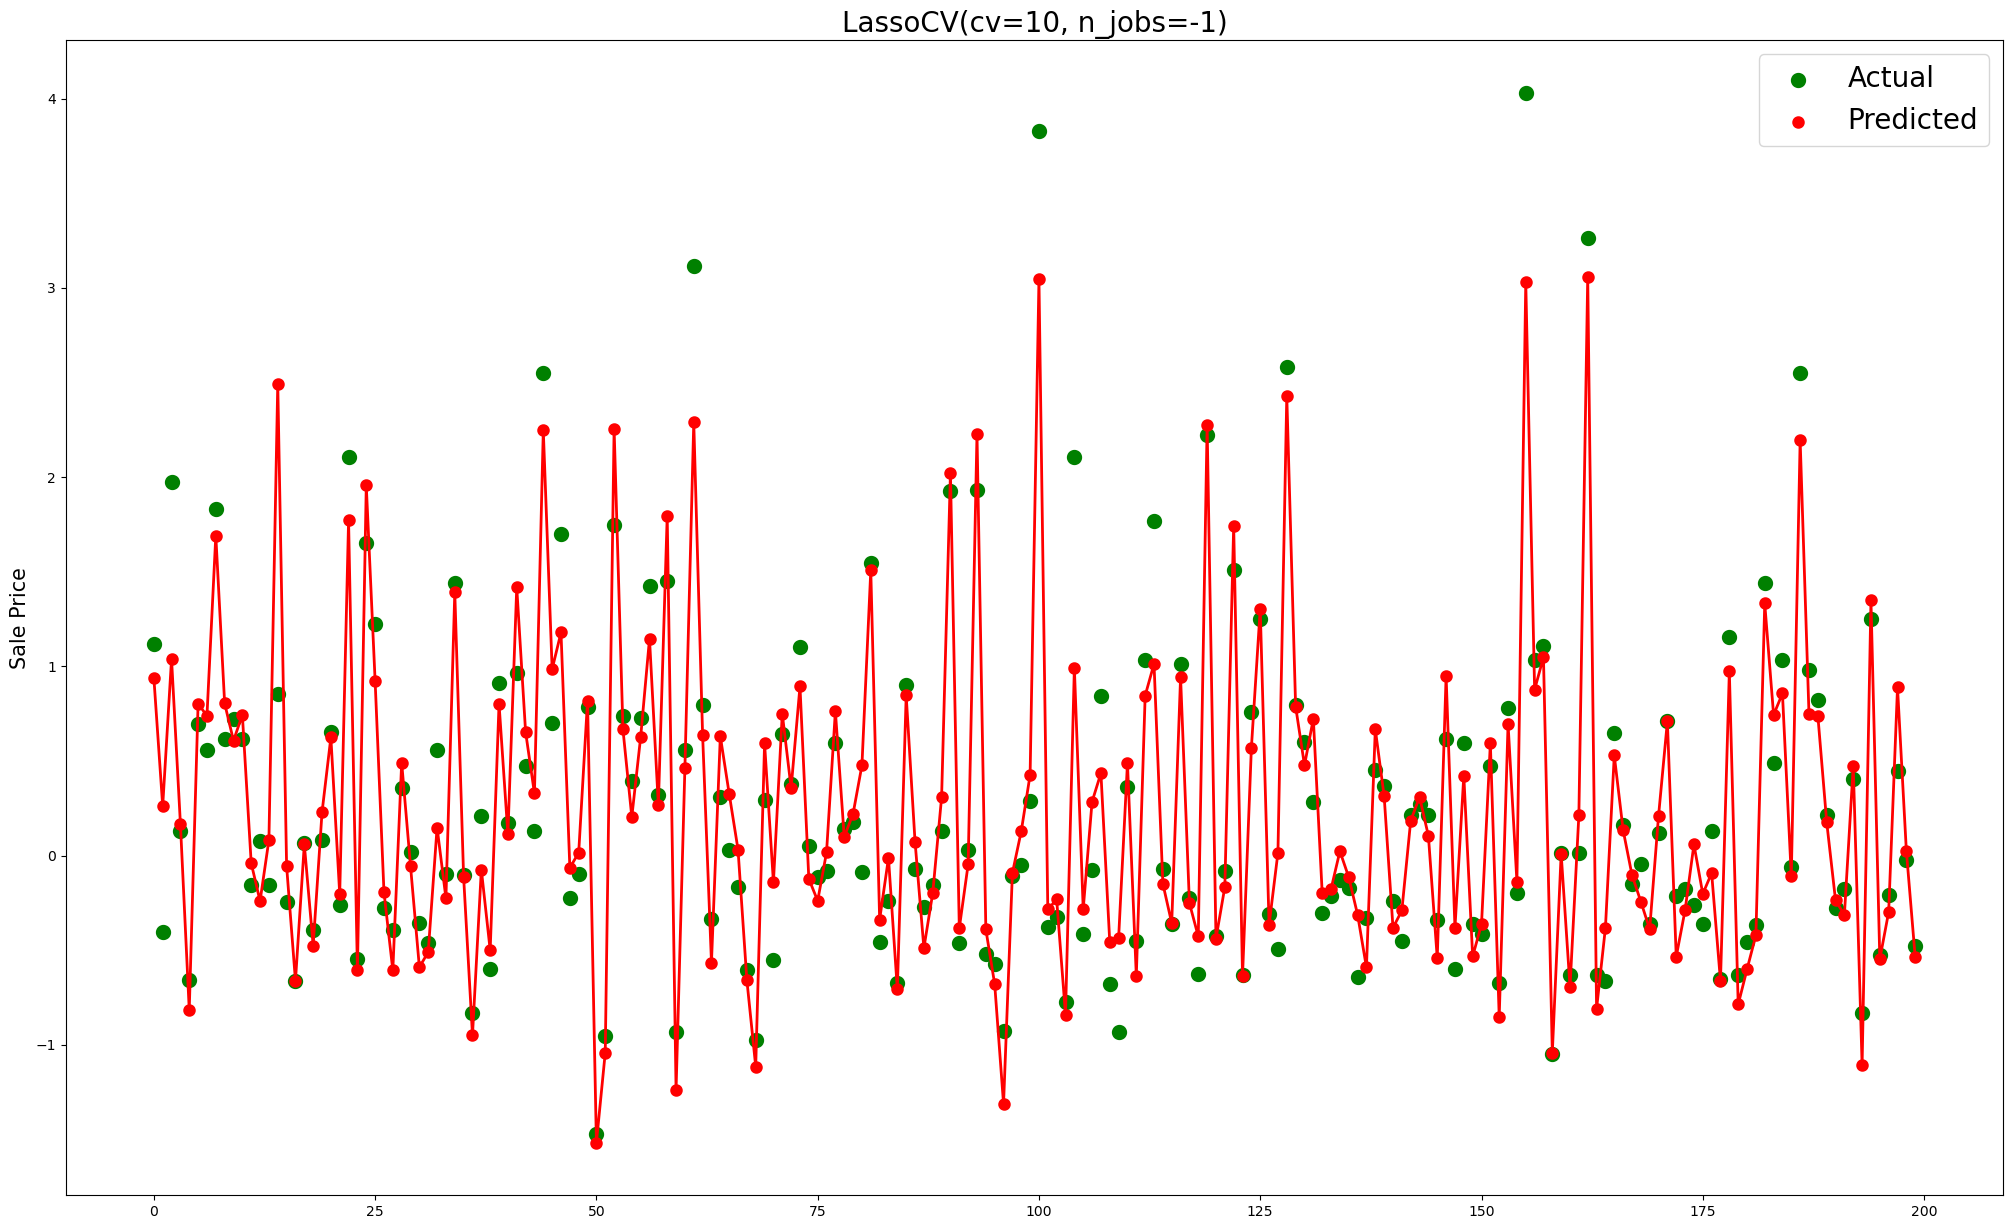

In [19]:
lassocv = prediction(X_train, y_train, X_test, y_test, LassoCV(cv=10, n_jobs=-1))

**StackingRegressor**

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.8s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.3s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.9s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   0.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.8s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   3.5s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=  10.3s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=  18.8s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=  19.5s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   3.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   3.5s
[Pipel

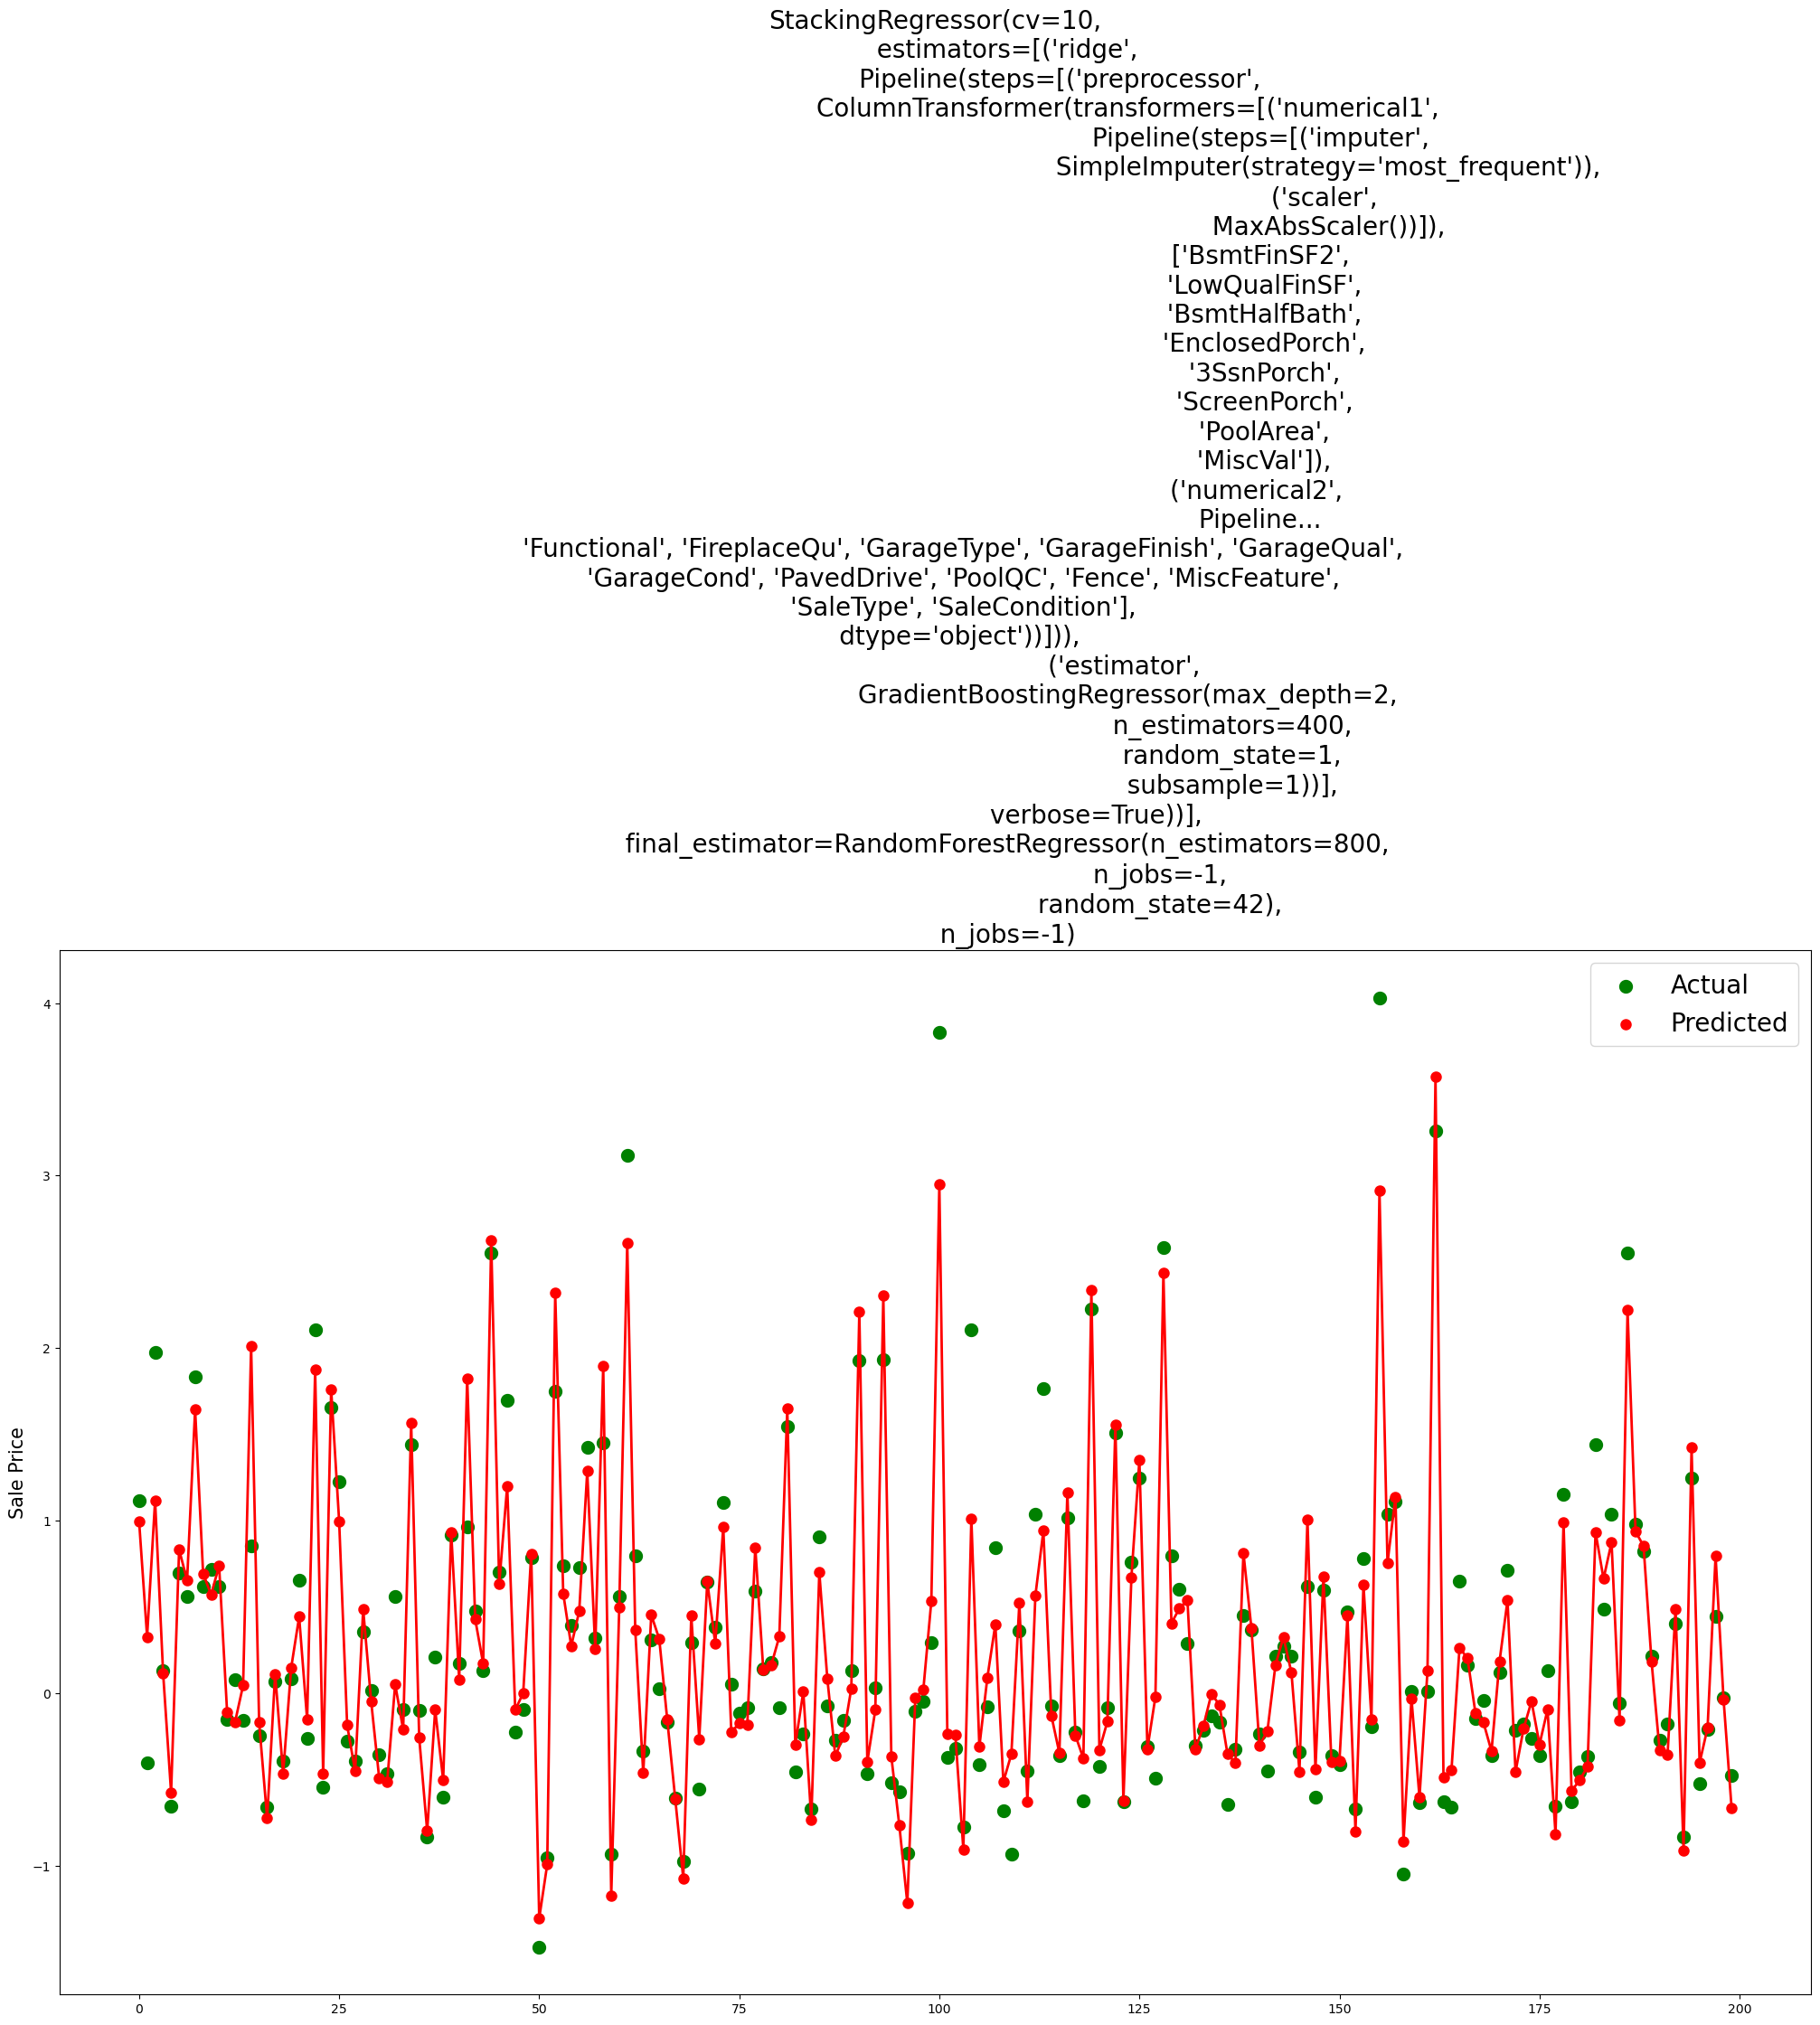

In [20]:
estimators = [('ridge', ridge), ('ridgecv', ridgecv), ('lassocv', lassocv), ('randomforest', randomforest), ('xgb', xgb), ('gradientboost', gradientboost)]
sr = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=800, random_state=42, n_jobs=-1), n_jobs=-1, cv = 10)

sr.fit(X_train, y_train.ravel())
pred = sr.predict(X_test)

rmse = mean_squared_error(y_test, pred, squared = False)
print("RMSE: %.4f" % rmse)
evs = explained_variance_score(y_test, pred)
print("EVS: %.4f" % evs)
score = sr.score(X_test, y_test)
print("Score: %.4f" % score)

MAX = 200
x = range(len(pred))[0:MAX]
plt.scatter(x,y_test[0:MAX],color='g', linewidths=5, label='Actual')
plt.scatter(x,pred[0:MAX],color='r', linewidths=3, label='Predicted')
plt.plot(pred[0:MAX], color = 'r', linewidth=2)
plt.ylabel('Sale Price', fontsize=15)
plt.title(sr, fontsize=20)
plt.legend(loc ="upper right", fontsize=20)
plt.show()

In [21]:
sr

StackingRegressor(cv=10,
                  estimators=[('ridge',
                               Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(transformers=[('numerical1',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('scaler',
                                                                                                  MaxAbsScaler())]),
                                                                                 ['BsmtFinSF2',
                                                                                  'LowQualFinSF',
                                                                                  'BsmtHalfBath',
                                                                                  'EnclosedPorch',
                                                                                  '3SsnPorch',
                                                                                  'ScreenPorch',
                                                                                  'PoolArea',
                                                                                  'MiscVal']),
                                                                                ('numerical2',
                                                                                 Pipeline...
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                                               ('estimator',
                                                GradientBoostingRegressor(max_depth=2,
                                                                          n_estimators=400,
                                                                          random_state=1,
                                                                          subsample=1))],
                                        verbose=True))],
                  final_estimator=RandomForestRegressor(n_estimators=800,
                                                        n_jobs=-1,
                                                        random_state=42),
                  n_jobs=-1)

**VotingRegressor**

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.5s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   2.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.6s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   0.5s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   3.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   5.2s[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   5.2s

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   5.2s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   0.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   5.5s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   2.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   4.9s
[Pipel

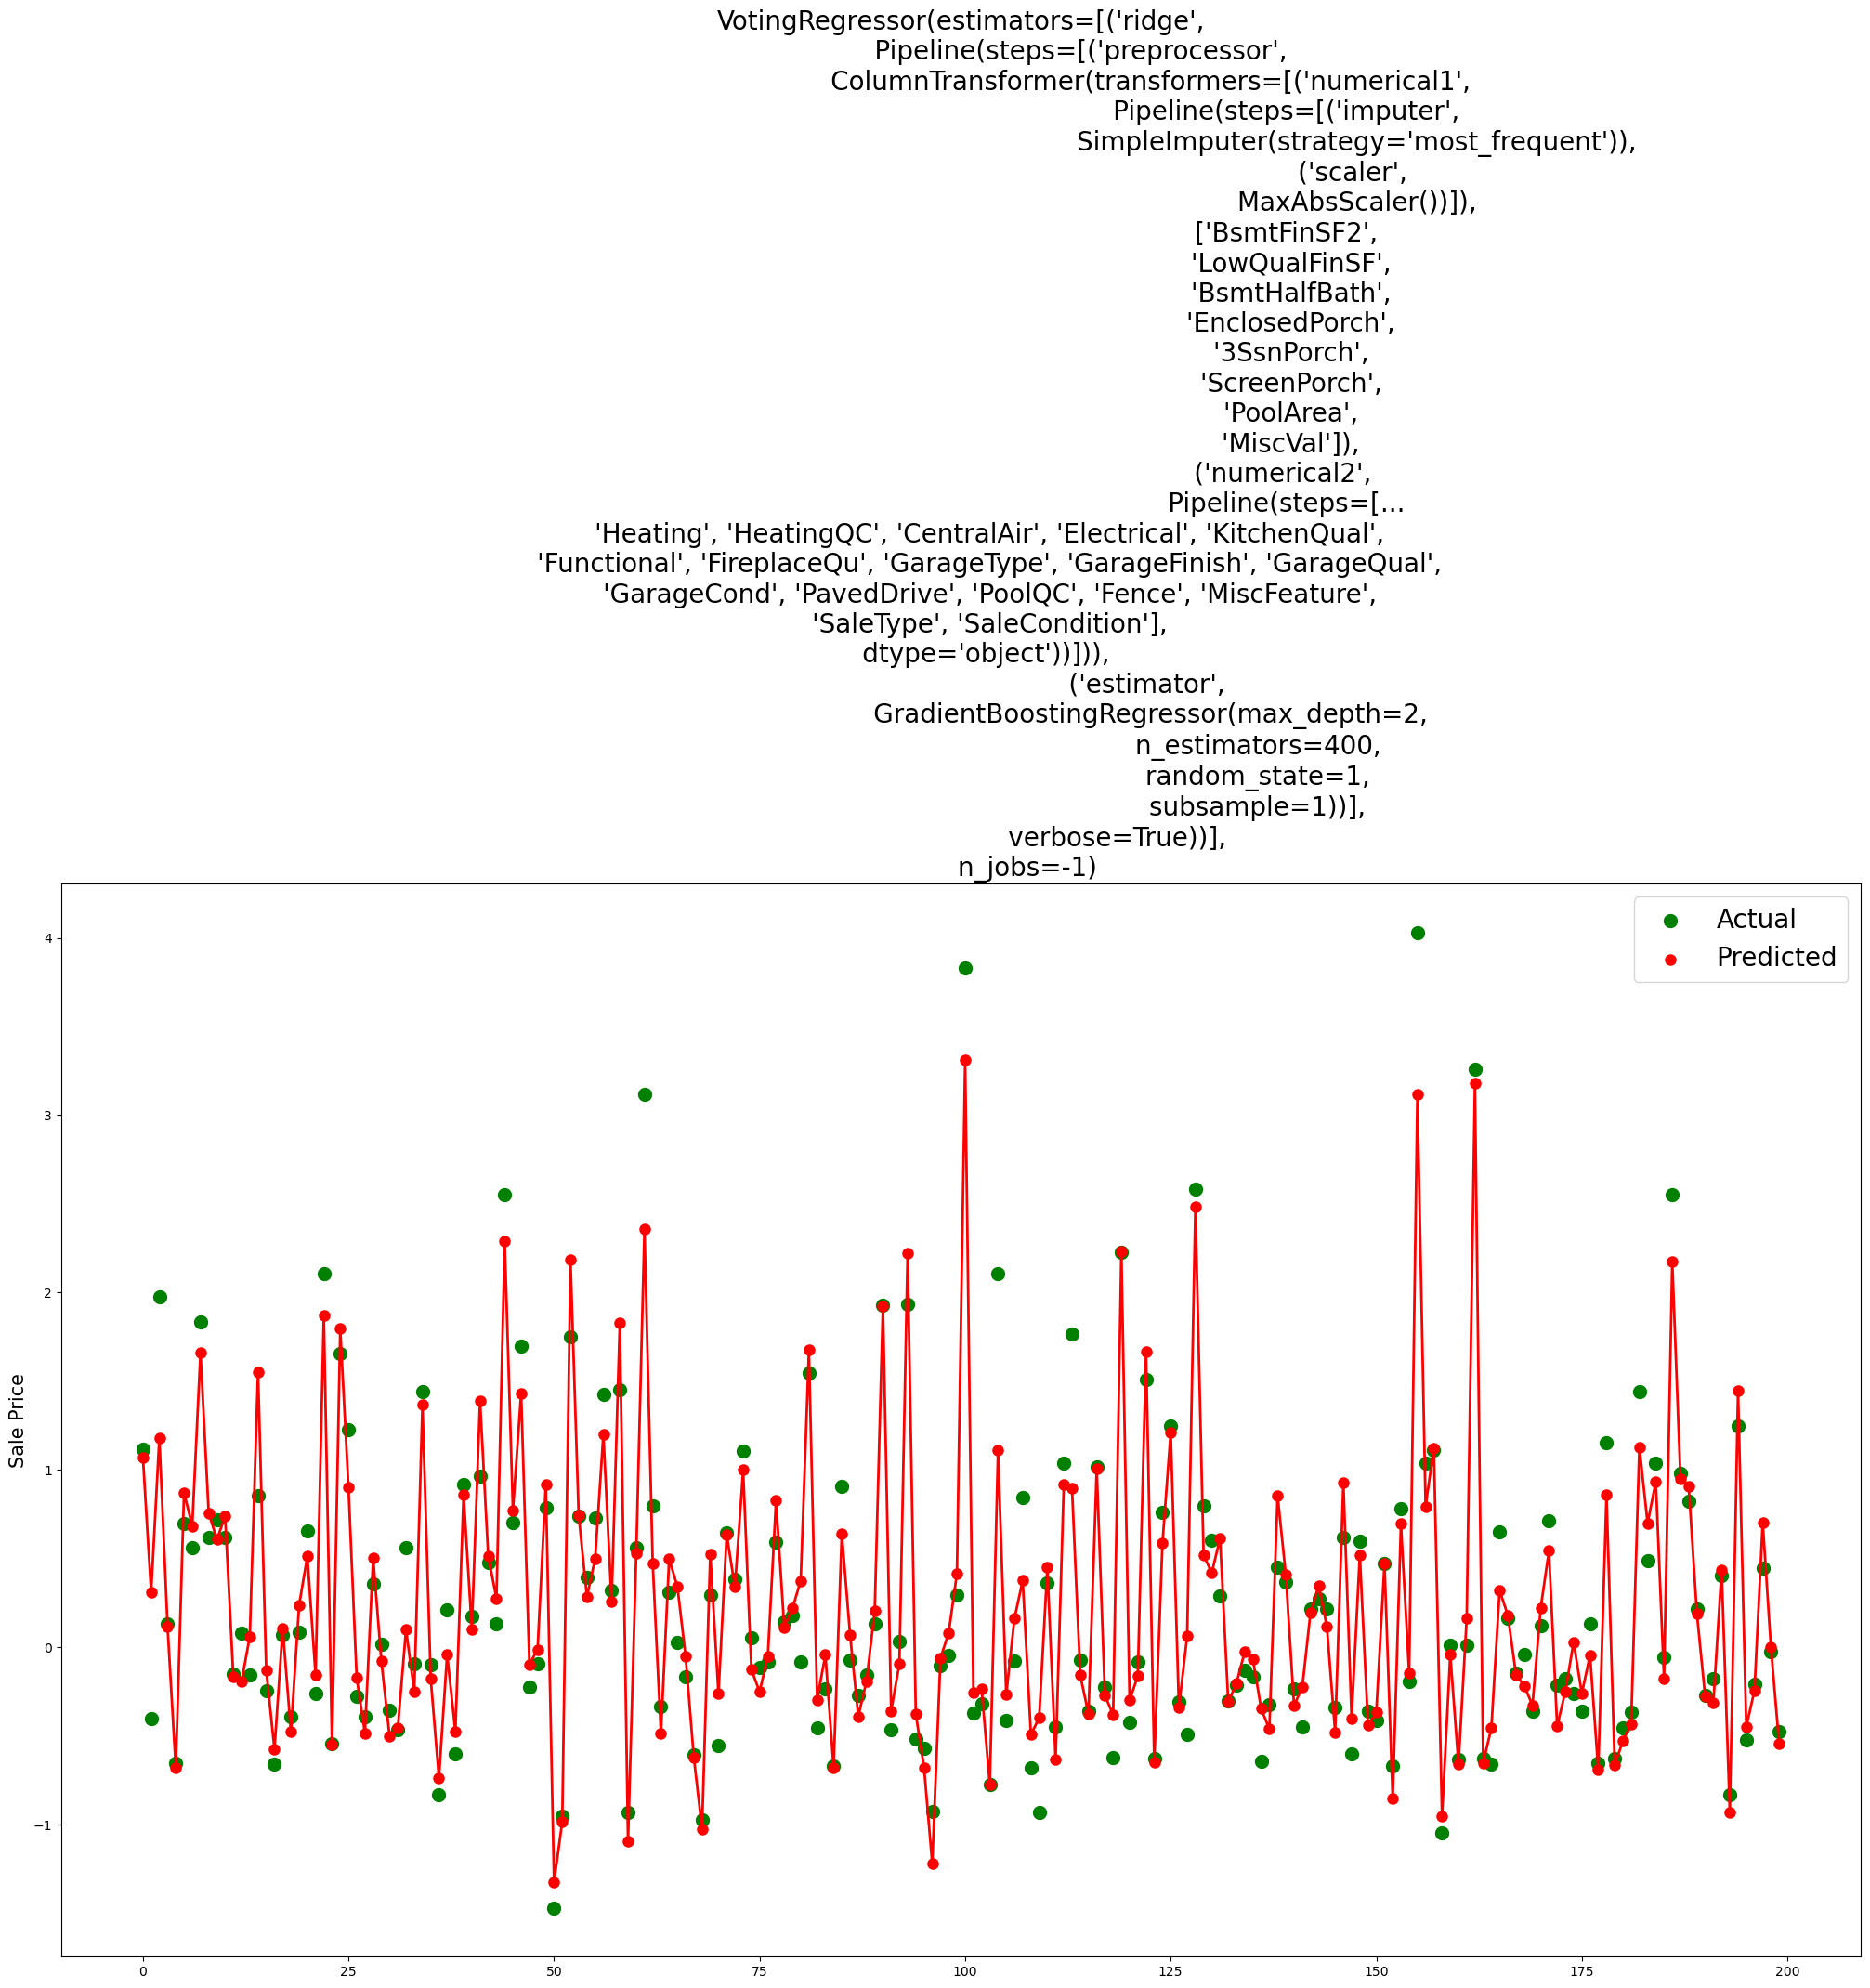

In [22]:
estimators = [('ridge', ridge), ('ridgecv', ridgecv), ('lassocv', lassocv), ('stacked', sr), ('randomforest', randomforest), ('xgboost', xgb), ('gradientboost', gradientboost)]
# vr = VotingRegressor(estimators=estimators, weights=[Weights['ridge'], Weights['ridgecv'], Weights['stacked'], Weights['randomforest'], Weights['xgboost'], Weights['gradientboost']], n_jobs=-1)
vr = VotingRegressor(estimators=estimators, n_jobs=-1) # Gave better result than above

vr.fit(X_train, y_train.ravel())
pred = vr.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared = False)
print("RMSE: %.4f" % rmse)
evs = explained_variance_score(y_test, pred)
print("EVS: %.4f" % evs)
score = vr.score(X_test, y_test)
print("Score: %.4f" % score)

MAX = 200
x = range(len(pred))[0:MAX]
plt.scatter(x,y_test[0:MAX],color='g', linewidths=5, label='Actual')
plt.scatter(x,pred[0:MAX],color='r', linewidths=3, label='Predicted')
plt.plot(pred[0:MAX], color = 'r', linewidth=2)
plt.ylabel('Sale Price', fontsize=15)
plt.title(vr, fontsize=20)
plt.legend(loc ="upper right", fontsize=20)
plt.show()

In [23]:
vr

VotingRegressor(estimators=[('ridge',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('scaler',
                                                                                                MaxAbsScaler())]),
                                                                               ['BsmtFinSF2',
                                                                                'LowQualFinSF',
                                                                                'BsmtHalfBath',
                                                                                'EnclosedPorch',
                                                                                '3SsnPorch',
                                                                                'ScreenPorch',
                                                                                'PoolArea',
                                                                                'MiscVal']),
                                                                              ('numerical2',
                                                                               Pipeline(steps=[...
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                                             ('estimator',
                                              GradientBoostingRegressor(max_depth=2,
                                                                        n_estimators=400,
                                                                        random_state=1,
                                                                        subsample=1))],
                                      verbose=True))],
                n_jobs=-1)

In [24]:
data = pd.read_csv(os.getcwd() + "/test.csv")

In [25]:
id_values = data.Id.values

In [26]:
data['MasVnrType'] = data['MasVnrType'].replace(np.nan, data.MasVnrType.value_counts().index[0])
data['Electrical'] = data['Electrical'].replace(np.nan, data.Electrical.value_counts().index[0])

In [27]:
pred = vr.predict(data.drop(['Id'], axis=1))
pred = ScaleTarget.inverse_transform(pred.reshape(-1,1))

In [28]:
result = pd.DataFrame(id_values, columns=['Id'])

In [29]:
result['Price'] = pred

In [30]:
result

,Id,Price
0,1461,118366.673153
1,1462,159936.779720
2,1463,181812.033706
3,1464,193136.085050
4,1465,189377.934906
...,...,...
1454,2915,82896.374456
1455,2916,82563.225836
1456,2917,170827.239357
1457,2918,111780.445321


In [31]:
result.to_csv(os.getcwd() + "/Result_p.csv", index=False)